In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
#librerias
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC # Clasificador SVM
from sklearn.linear_model import LogisticRegression # Clasificador Regresión Logística
from sklearn.model_selection import train_test_split # Para dividir el dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Métricas de evaluación
from skimage.feature import local_binary_pattern # Para extracción de características LBP
from skimage.morphology import remove_small_objects, remove_small_holes # Operaciones morfológicas
from tqdm import tqdm # Para barras de progreso
import cv2

#Configuración Inicial y Descomprensión

In [4]:
zip_path = '/content/drive/MyDrive/PROCESAMIENTO DE IMAGENES /archive (6).zip'

extract_path = '/content/data'

os.makedirs(extract_path, exist_ok=True)

print(f"Descomprimiendo {zip_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("¡Archivos descomprimidos exitosamente!")

Descomprimiendo /content/drive/MyDrive/PROCESAMIENTO DE IMAGENES /archive (6).zip...
¡Archivos descomprimidos exitosamente!


In [26]:
DATA_DIR = r'/content/data/chest_xray'
#PARA HACER LA IMAGEN 224 x 224

#Carga de datos

In [28]:
# Definimos el tamaño al que redimensionaremos las imágenes para uniformidad
IMG_SIZE = 224


In [30]:
# Función para cargar rutas de imágenes y sus etiquetas
def load_image_paths_and_labels(base_dir):
    """
    Carga las rutas de las imágenes y sus etiquetas (0 para NORMAL, 1 para PNEUMONIA).
    """
    normal_dir = os.path.join(base_dir, "NORMAL")
    pneumonia_dir = os.path.join(base_dir, "PNEUMONIA")

    normal_paths = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    pneumonia_paths = [os.path.join(pneumonia_dir, f) for f in os.listdir(pneumonia_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    image_paths = normal_paths + pneumonia_paths
    labels = [0] * len(normal_paths) + [1] * len(pneumonia_paths) # 0: Normal, 1: Pneumonia

    print(f"Cargadas {len(normal_paths)} imágenes NORMAL y {len(pneumonia_paths)} imágenes PNEUMONIA de {os.path.basename(base_dir)}.")
    return image_paths, labels

# Cargar las rutas para los datasets de entrenamiento, validación y prueba
train_image_paths, train_labels = load_image_paths_and_labels(os.path.join(DATA_DIR, 'train'))
val_image_paths, val_labels = load_image_paths_and_labels(os.path.join(DATA_DIR, 'val'))
test_image_paths, test_labels = load_image_paths_and_labels(os.path.join(DATA_DIR, 'test'))

print(f"\nTotal imágenes de entrenamiento: {len(train_image_paths)}")
print(f"Total imágenes de validación: {len(val_image_paths)}")
print(f"Total imágenes de prueba: {len(test_image_paths)}")

Cargadas 1341 imágenes NORMAL y 3875 imágenes PNEUMONIA de train.
Cargadas 8 imágenes NORMAL y 8 imágenes PNEUMONIA de val.
Cargadas 234 imágenes NORMAL y 390 imágenes PNEUMONIA de test.

Total imágenes de entrenamiento: 5216
Total imágenes de validación: 16
Total imágenes de prueba: 624


#Preprocesamiento de Imágenes

Procesando y visualizando: NORMAL2-IM-1351-0001.jpeg


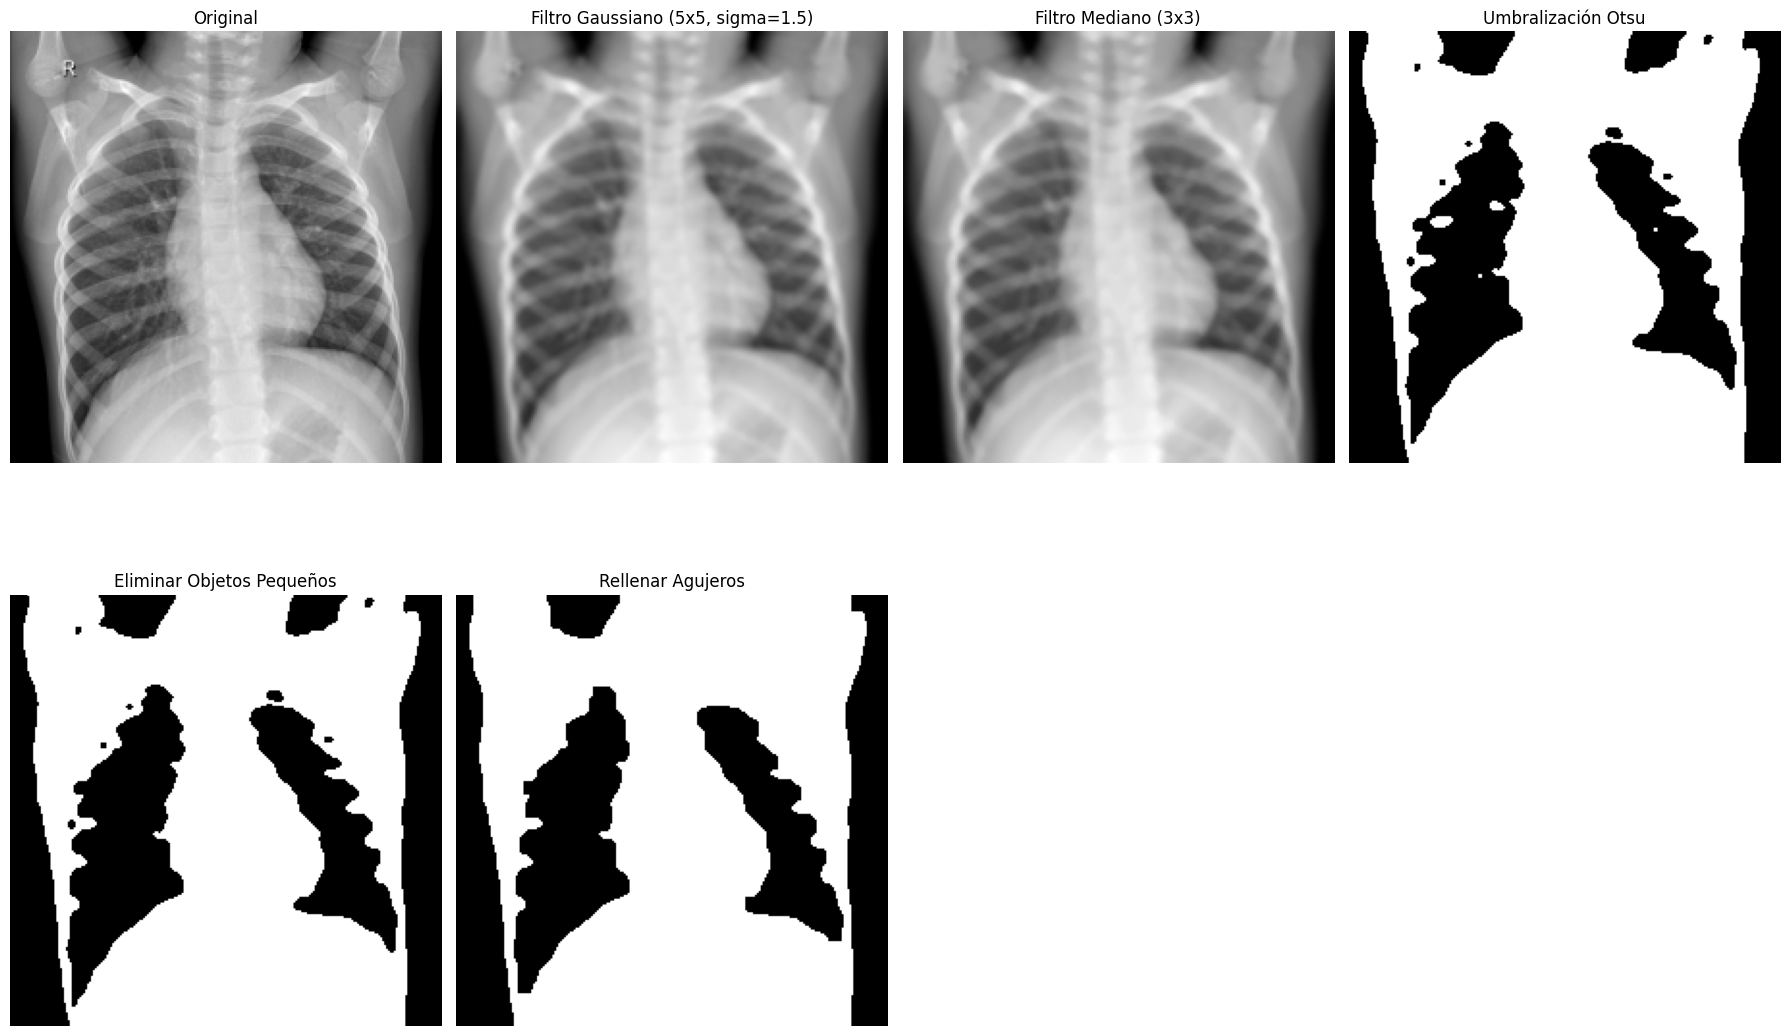

In [45]:
def preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE), visualize=False):
#Leer imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#Redimensionar la imagen para estandarizar el tamaño
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    original_img = img.copy()

    if visualize:
        plt.figure(figsize=(18, 12))
        plt.subplot(2, 4, 1)
        plt.title("Original")
        plt.imshow(original_img, cmap='gray')
        plt.axis('off')

#Filtro Gaussiano: Suaviza la imagen y reduce ruido de alta frecuencia
    img_gaussian = cv2.GaussianBlur(img, (5, 5), sigmaX=1.5)
    if visualize:
        plt.subplot(2, 4, 2)
        plt.title("Filtro Gaussiano (5x5, sigma=1.5)")
        plt.imshow(img_gaussian, cmap='gray')
        plt.axis('off')

#Filtro Mediano 3x3: Elimina ruido "sal y pimienta" sin difuminar bordes
    img_median = cv2.medianBlur(img_gaussian, 3)
    if visualize:
        plt.subplot(2, 4, 3)
        plt.title("Filtro Mediano (3x3)")
        plt.imshow(img_median, cmap='gray')
        plt.axis('off')

#Umbralización Global (Método de Otsu): Segmenta el área de interés (pulmones)
    _, img_thresh = cv2.threshold(img_median, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if visualize:
        plt.subplot(2, 4, 4)
        plt.title("Umbralización Otsu")
        plt.imshow(img_thresh, cmap='gray')
        plt.axis('off')

#Operaciones Morfológicas:
    img_cleaned = remove_small_objects(img_thresh.astype(bool), min_size=500).astype(np.uint8) * 255
    if visualize:
        plt.subplot(2, 4, 5)
        plt.title("Eliminar Objetos Pequeños")
        plt.imshow(img_cleaned, cmap='gray')
        plt.axis('off')
    kernel = np.ones((7, 7), np.uint8)
    img_closed = cv2.morphologyEx(img_cleaned, cv2.MORPH_CLOSE, kernel)

    img_filled_holes = remove_small_holes(img_closed.astype(bool), area_threshold=500).astype(np.uint8) * 255
    if visualize:
        plt.subplot(2, 4, 6)
        plt.title("Rellenar Agujeros")
        plt.imshow(img_filled_holes, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return img_filled_holes

#Demostración del Preprocesamiento

ejemplo = train_image_paths[10]
print(f"Procesando y visualizando: {os.path.basename(ejemplo)}")
processed_example_img = preprocess_image(ejemplo, visualize=True)

#Visualización del Preprocesamiento en Múltiples Imágenes

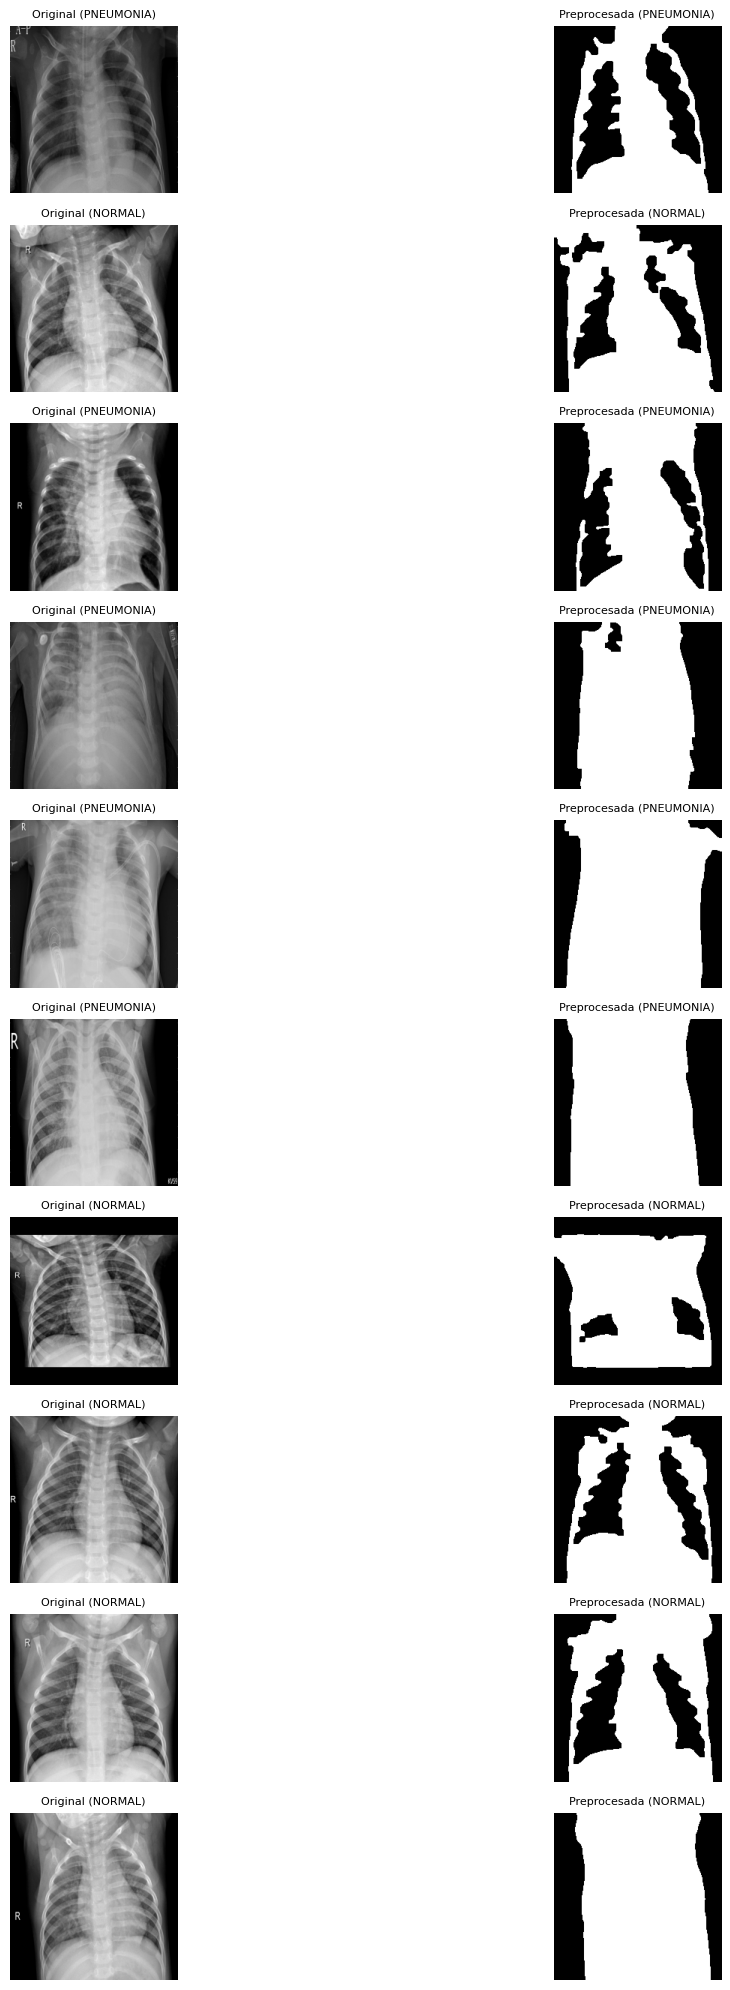

In [46]:
np.random.seed(42)
random_indices = np.random.choice(len(train_image_paths), 10, replace=False)

plt.figure(figsize=(15, 20))

for i, idx in enumerate(random_indices):
    img_path = train_image_paths[idx]
    label = "NORMAL" if train_labels[idx] == 0 else "PNEUMONIA"

#Cargar y preprocesar la imagen
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if original_img is None:
        print(f"Skipping {img_path} due to loading error.")
        continue
    original_img_resized = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    processed_img = preprocess_image(img_path)

    if processed_img is None:
        continue
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(original_img_resized, cmap='gray')
    plt.title(f"Original ({label})", fontsize=8)
    plt.axis('off')

#Mostrar la imagen preprocesada
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title(f"Preprocesada ({label})", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

#Extracción de Características

In [50]:
def extract_features(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")

    n_bins_lbp = 59
    lbp_hist, _ = np.histogram(lbp.ravel(), density=True, bins=n_bins_lbp, range=(0, n_bins_lbp))
    mean = np.mean(image)
    std = np.std(image)
    features = np.concatenate([hist, lbp_hist, [mean, std]])
    return features

print("Extracción de Características")
if processed_example_img is not None:
    extracted_features = extract_features(processed_example_img)
    print(f"Dimensiones del vector extraído: {extracted_features.shape}")
    print(f"Primeros 10 valores: {extracted_features[:10]}")
    print(f"Últimos 10 valores: {extracted_features[-10:]}")
else:
    print("No se pudo extraer características porque la imagen de ejemplo no se procesó correctamente.")

Extracción de Características
Dimensiones del vector extraído: (317,)
Primeros 10 valores: [17869.     0.     0.     0.     0.     0.     0.     0.     0.     0.]
Últimos 10 valores: [  0.           0.           0.           0.           0.
   0.           0.           0.         164.18775909 122.1075687 ]


#Clasificador Tradicional(SVM Y Regresión Logística)

In [51]:
def prepare_data_for_classical_model(image_paths, labels):

    features = []
    processed_labels = []

    for i, path in enumerate(tqdm(image_paths, desc="Procesando imágenes")):
        img_processed = preprocess_image(path)
        if img_processed is not None:
            feat = extract_features(img_processed)
            features.append(feat)
            processed_labels.append(labels[i])
        else:
            print(f"Advertencia: Saltando la imagen {path} debido a un error de procesamiento.")

    return np.array(features), np.array(processed_labels)

In [52]:
# Preparar los datos de entrenamiento y prueba
X_train, y_train = prepare_data_for_classical_model(train_image_paths, train_labels)
X_test, y_test = prepare_data_for_classical_model(test_image_paths, test_labels)

print(f"\nDimension datos de entrenamiento: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Dimension datos de prueba: X_test={X_test.shape}, y_test={y_test.shape}")

print("\n--- Entrenamiento y Evaluación de Modelos Clásicos ---")


Procesando imágenes: 100%|██████████| 624/624 [00:16<00:00, 38.42it/s]


Dimension datos de entrenamiento: X_train=(5216, 317), y_train=(5216,)
Dimension datos de prueba: X_test=(624, 317), y_test=(624,)

--- Entrenamiento y Evaluación de Modelos Clásicos ---


In [53]:
print("\nModelo SVM Lineal")
svm_model = SVC(kernel='linear', probability=True, random_state=42)
print("Entrenando SVM...")
svm_model.fit(X_train, y_train)
print("Entrenamiento de SVM completado.")



Modelo SVM Lineal
Entrenando SVM...
Entrenamiento de SVM completado.



--- Métricas de Evaluación para SVM ---
Accuracy (Exactitud): 0.6250

Reporte de Clasificación:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624


Matriz de Confusión para SVM:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


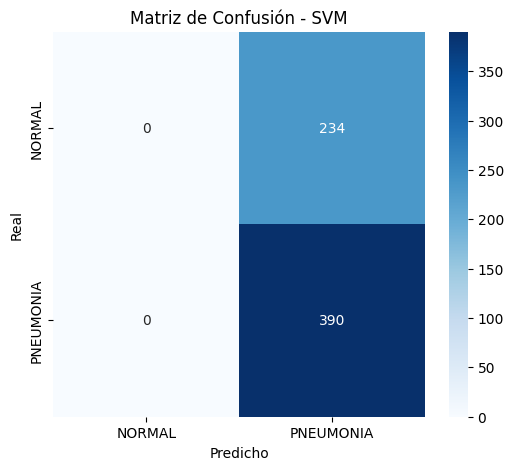

AUC-ROC para SVM: 0.5800


In [54]:
# Evaluar SVM en el conjunto de prueba
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1] # Probabilidad de la clase positiva (Pneumonia)

print("\n--- Métricas de Evaluación para SVM ---")
print(f"Accuracy (Exactitud): {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm, target_names=['NORMAL', 'PNEUMONIA']))

print("\nMatriz de Confusión para SVM:")
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - SVM')
plt.show()

# Calcula el AUC-ROC
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)
print(f"AUC-ROC para SVM: {roc_auc_svm:.4f}")


### Modelo de Regresión Logística ###
Entrenando Regresión Logística...
Entrenamiento de Regresión Logística completado.

--- Métricas de Evaluación para Regresión Logística ---
Accuracy (Exactitud): 0.6250

Reporte de Clasificación:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624


Matriz de Confusión para Regresión Logística:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


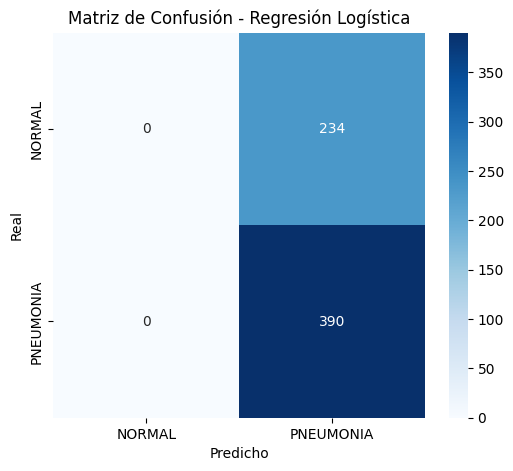

AUC-ROC para Regresión Logística: 0.5456


In [55]:
# --- Modelo 2: Regresión Logística ---
print("\n### Modelo de Regresión Logística ###")
logistic_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000) # 'liblinear' es bueno para datasets pequeños
print("Entrenando Regresión Logística...")
logistic_model.fit(X_train, y_train)
print("Entrenamiento de Regresión Logística completado.")

# Evaluar Regresión Logística en el conjunto de prueba
y_pred_lr = logistic_model.predict(X_test)
y_prob_lr = logistic_model.predict_proba(X_test)[:, 1] # Probabilidad de la clase positiva (Pneumonia)

print("\n--- Métricas de Evaluación para Regresión Logística ---")
print(f"Accuracy (Exactitud): {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_lr, target_names=['NORMAL', 'PNEUMONIA']))

print("\nMatriz de Confusión para Regresión Logística:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# Calcula el AUC-ROC
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"AUC-ROC para Regresión Logística: {roc_auc_lr:.4f}")


#Testeo de Modelo

In [56]:
import random
print("Realizando una Prueba de Uso con una Imagen Individual")

idx_to_test = random.choice(range(len(test_image_paths)))

image_path_to_test = test_image_paths[idx_to_test]
true_label = test_labels[idx_to_test]
true_label_name = "NORMAL" if true_label == 0 else "PNEUMONIA"

print(f"Probando con la imagen: {os.path.basename(image_path_to_test)}")
print(f"Etiqueta Real: {true_label_name}")

# --- Paso 1: Preprocesamiento de la imagen ---
print("Preprocesando la imagen...")
processed_img_for_test = preprocess_image(image_path_to_test)

if processed_img_for_test is None:
    print(f"No se pudo preprocesar la imagen {image_path_to_test}. Saliendo.")
else:
    print("Extrayendo características de la imagen...")
    features_for_test = extract_features(processed_img_for_test)
    features_for_test_reshaped = features_for_test.reshape(1, -1)
    print(f"Dimensiones de las características para la prueba: {features_for_test_reshaped.shape}")

Realizando una Prueba de Uso con una Imagen Individual
Probando con la imagen: NORMAL2-IM-0033-0001.jpeg
Etiqueta Real: NORMAL
Preprocesando la imagen...
Extrayendo características de la imagen...
Dimensiones de las características para la prueba: (1, 317)


#Predicciones con modelos Entrenados

In [58]:
#Realizar predicciones con los modelos
#Predicción con SVM
svm_prediction = svm_model.predict(features_for_test_reshaped)[0]
svm_proba = svm_model.predict_proba(features_for_test_reshaped)[0]
svm_predicted_label_name = "NORMAL" if svm_prediction == 0 else "PNEUMONIA"
svm_confidence_normal = svm_proba[0]
svm_confidence_pneumonia = svm_proba[1]

print(f"  [SVM] Predicción: {svm_predicted_label_name} (Confianza NORMAL: {svm_confidence_normal:.4f}, PNEUMONIA: {svm_confidence_pneumonia:.4f})")

#Predicción con Regresión Logística
lr_prediction = logistic_model.predict(features_for_test_reshaped)[0]
lr_proba = logistic_model.predict_proba(features_for_test_reshaped)[0]
lr_predicted_label_name = "NORMAL" if lr_prediction == 0 else "PNEUMONIA"
lr_confidence_normal = lr_proba[0]
lr_confidence_pneumonia = lr_proba[1]

print(f"  [Regresión Logística] Predicción: {lr_predicted_label_name} (Confianza NORMAL: {lr_confidence_normal:.4f}, PNEUMONIA: {lr_confidence_pneumonia:.4f})")

#Comparar con la etiqueta real
print(f"\nEtiqueta Real: {true_label_name}")
print(f"  SVM {'CORRECTO' if svm_prediction == true_label else 'INCORRECTO'}")
print(f"  Regresión Logística {'CORRECTO' if lr_prediction == true_label else 'INCORRECTO'}")

  [SVM] Predicción: PNEUMONIA (Confianza NORMAL: 0.3066, PNEUMONIA: 0.6934)
  [Regresión Logística] Predicción: PNEUMONIA (Confianza NORMAL: 0.3153, PNEUMONIA: 0.6847)

Etiqueta Real: NORMAL
  SVM INCORRECTO
  Regresión Logística INCORRECTO


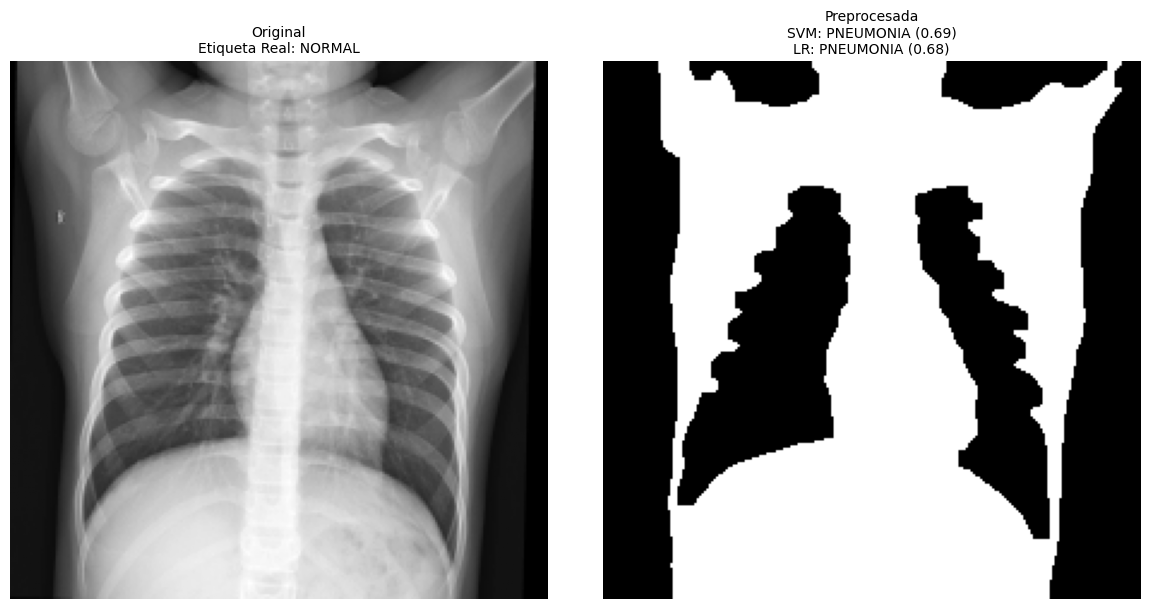

In [60]:
#Visualizar la imagen original y preprocesada con las predicciones
original_img = cv2.imread(image_path_to_test, cv2.IMREAD_GRAYSCALE)
original_img_resized = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_img_resized, cmap='gray')
plt.title(f"Original\nEtiqueta Real: {true_label_name}", fontsize=10)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_img_for_test, cmap='gray')
plt.title(f"Preprocesada\nSVM: {svm_predicted_label_name} ({svm_confidence_pneumonia:.2f})\nLR: {lr_predicted_label_name} ({lr_confidence_pneumonia:.2f})", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()